# Plot preSource Time in Selected Objects

 work with Weakly_2023_44
- use jupyter kernel LSST
- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab
- creation date : 2023/12/30
- update : 2023/12/30


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm 
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.dates as mdates
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
import pandas as pd

import matplotlib.ticker                         # here's where the formatter is
import os
import re
import pandas as pd
import pickle

plt.rcParams["figure.figsize"] = (16,10)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

In [2]:
# A repo which exists at the USDF, contains data from various instruments and
REPO = '/repo/embargo'

from lsst.daf.butler import Butler
from pprint import pprint

# Here we specify a default collection to use
my_collection = "LATISS/runs/AUXTEL_DRP_IMAGING_2023-11A-10A-09AB-08ABC-07AB-05AB/w_2023_46/PREOPS-4553"
butler = Butler(REPO, collections=my_collection)
registry = butler.registry

In [3]:
#import lsst.sphgeom
from  lsst.geom import SpherePoint, Angle
import lsst.sphgeom

In [4]:
Angle(3.1415).asDegrees()

179.9946913403481

In [5]:
Angle(3.1415).asRadians()

3.1415

In [6]:
SpherePoint(Angle(3.1415),Angle(1.0))

SpherePoint(179.9946913403481*degrees, 57.29577951308232*degrees)

In [7]:
import astropy.coordinates as coord
import astropy.units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord
from astropy import coordinates

In [8]:
import pandas as pd

In [9]:
def convert_fluxtomag(x) :
    """
    The object and source catalogs store only fluxes. There are hundreds of flux-related columns, 
    and to store them also as magnitudes would be redundant, and a waste of space.
    All flux units are nanojanskys. The AB Magnitudes Wikipedia page provides a concise resource 
    for users unfamiliar with AB magnitudes and jansky fluxes. To convert to AB magnitudes use:
    As demonstrated in Section 2.3.2, to add columns of magnitudes after retrieving columns of flux, users can do this:
    results_table['r_calibMag'] = -2.50 * numpy.log10(results_table['r_calibFlux']) + 31.4
    results_table['r_cModelMag'] = -2.50 * numpy.log10(results_table['r_cModelFlux']) + 31.4
    (from DP0 tutorial)
    """
    return -2.50 * np.log10(x) + 31.4

## Config

### Galactic Plane

In [10]:
gal_long = np.linspace(-180.,180,360)
gal_lat = np.zeros((360))

coordinates_galactic_planes = SkyCoord(l=gal_long*u.degree, b=gal_lat*u.degree, frame='galactic')
gp_radec = coordinates_galactic_planes.transform_to('icrs')  

gp_ra_toplot = coordinates.Angle(gp_radec.ra.degree*u.degree)
gp_ra_toplot = gp_ra_toplot.wrap_at(180*u.degree)

### Sources

In [11]:
file = "preSourceTable_202312.csv"
file_visit = "preSourceTablevisit_202312.csv"

In [12]:
suptitle = "Pre-Sources, Auxtel phot 2023"

## Skymap, Tracts and Patchs

In [13]:
Auxtel2023_tracts = [ 5616,5634,5615,10644,383,8188,3863,455,452,5839,10643,382]

In [14]:
skymap_auxtel ='latiss_v1'

In [15]:
skymap = butler.get('skyMap', skymap=skymap_auxtel, collections=my_collection)

In [16]:
with open('Latiss_tractspatchs.pickle', 'rb') as handle:
    tracts_patchs_dict = pickle.load(handle)

In [17]:
tracts_patchs_dict

{5616: array([335, 355, 358, 336, 337, 338, 316, 357, 317, 356]),
 5634: array([ 91,  52,  93,  72,  92, 109, 110,  54,  71,  53,  55, 112, 111,
         74,  73,  90]),
 5615: array([332, 333, 312, 313, 295, 331, 276, 275, 294, 293, 314, 274]),
 10644: array([166, 184, 183, 201, 161, 180, 207, 188, 202, 182, 189, 208, 164,
        181, 185, 165, 203, 162]),
 383: array([359, 360]),
 8188: array([48, 65, 47, 28, 46, 66, 27]),
 3863: array([241, 243, 242, 260, 261, 222, 262, 224, 223]),
 455: array([52, 33, 51, 32, 14, 53, 34, 15, 13]),
 452: array([42, 44, 25, 24, 63, 23, 43, 62]),
 5839: array([9, 7, 8]),
 10643: array([171, 190]),
 382: array([343, 342])}

### Should try Tracts
- 5615 - OK , Not in our galaxy
- 5616 - Non, 1 nuit
- 5839 - Non, 1 nuit
- 5634 - OK - Galaxie Plane

In [18]:
tract_selected = 5615

In [19]:
tractInfo = skymap.generateTract(tract_selected)

In [20]:
tractInfo.contains 

<bound method TractInfo.contains of TractInfo(id=5615, ctrCoord=[-0.4548159976772596, -0.7877644160721412, -0.4154150130018864])>

In [21]:
def SourceInTract(row):
    #coord_dec
    #coord_ra
    #print(row)
    try:
        ra = row["ra"]
        dec = row["dec"]
        ra_rad = ra*np.pi/180.
        dec_rad = dec*np.pi/180.
        spherepoint = SpherePoint(Angle(ra_rad),Angle(dec_rad))
        flag = tractInfo.contains( spherepoint)
        return flag
    except Exception as err:
        print(f"Unexpected {err=}, {type(err)=}")
        return False
        
    

### Selected Objects

In [22]:
fileobjects_in = "objectTableselected_202312.csv"

In [23]:
df_selobj = pd.read_csv(fileobjects_in)

In [24]:
index_selected_object = 2
the_obj=df_selobj.iloc[index_selected_object]

In [25]:
the_obj

Unnamed: 0                         25112
objectId             2229049818594936752
tabid_idx                             44
x                           29711.116965
y                            46203.31836
coord_ra                       239.96313
coord_dec                     -24.053676
tract                               5615
patch                                294
refExtendedness                      0.0
detect_isPrimary                    True
detect_isIsolated                  False
g_calibFlux               4600296.135923
g_psfFlux                 6199224.110384
g_cModelFlux              6208825.887375
g_kronFlux                6178861.265234
r_calibFlux               6607333.531866
r_psfFlux                 8620695.786613
r_cModelFlux              8680854.162264
r_kronFlux                8554545.088192
i_calibFlux               7814283.734559
i_psfFlux                 9909984.385844
i_cModelFlux                9943336.8897
i_kronFlux                9944063.604853
g_psfMag        

In [26]:
suptitle += f" Object {the_obj.objectId }"

In [27]:
the_obj.objectId 

2229049818594936752

In [28]:
vect_to_object = lsst.sphgeom.UnitVector3d(lsst.sphgeom.LonLat.fromDegrees(the_obj.coord_ra, the_obj.coord_dec))

In [29]:
spherePointCenter = lsst.geom.SpherePoint(the_obj.coord_ra*lsst.geom.degrees, the_obj.coord_dec*lsst.geom.degrees)

## Input

In [30]:
df = pd.read_csv(file,index_col=0)
df_visit = pd.read_csv(file_visit,index_col=0)

In [31]:
list_of_columns = sorted(list(df_visit.columns))

In [32]:
for col in list_of_columns:
    print(col)

ap03Flux
ap03FluxErr
ap03Flux_flag
ap06Flux
ap06FluxErr
ap06Flux_flag
ap09Flux
ap09FluxErr
ap09Flux_flag
ap12Flux
ap12FluxErr
ap12Flux_flag
ap17Flux
ap17FluxErr
ap17Flux_flag
ap25Flux
ap25FluxErr
ap25Flux_flag
ap35Flux
ap35FluxErr
ap35Flux_flag
ap50Flux
ap50FluxErr
ap50Flux_flag
ap70Flux
ap70FluxErr
ap70Flux_flag
apFlux_12_0_flag
apFlux_12_0_flag_apertureTruncated
apFlux_12_0_flag_sincCoeffsTruncated
apFlux_12_0_instFlux
apFlux_12_0_instFluxErr
apFlux_17_0_flag
apFlux_17_0_instFlux
apFlux_17_0_instFluxErr
apFlux_35_0_flag
apFlux_35_0_instFlux
apFlux_35_0_instFluxErr
apFlux_50_0_flag
apFlux_50_0_instFlux
apFlux_50_0_instFluxErr
band
blendedness_abs
blendedness_flag
blendedness_flag_noCentroid
blendedness_flag_noShape
calibFlux
calibFluxErr
calib_astrometry_used
calib_detected
calib_photometry_reserved
calib_photometry_used
calib_psf_candidate
calib_psf_reserved
calib_psf_used
ccdVisitId
centroid_flag
centroid_flag_almostNoSecondDerivative
centroid_flag_badError
centroid_flag_edge
centro

## Selection

In [33]:
df.dropna(inplace=True)
selection1 = df["extendedness_flag"] == False
selection2 = df["detect_isPrimary"] == True
df = df[selection1 & selection2 ]

### Selection for one object

In [34]:
#df["inptract"]=df[["ra","dec"]].apply(SourceInTract)

In [35]:
cut_arcsc = 10.0

In [36]:
all_angles = []
for index, row in df.iterrows():
    spt = lsst.geom.SpherePoint(row["coord_ra"]*lsst.geom.degrees, row["coord_dec"]*lsst.geom.degrees)
    ang = spherePointCenter.separation(spt)
    ang_arcsec = ang.asArcseconds()
    all_angles.append(ang_arcsec)

In [37]:
df["sep"] = all_angles

In [38]:
df["sep"].min() 

0.06337353566731276

In [39]:
df.sort_values(by=["dateobs"],inplace=True)

Text(0.5, 0.98, 'Pre-Sources, Auxtel phot 2023 Object 2229049818594936752')

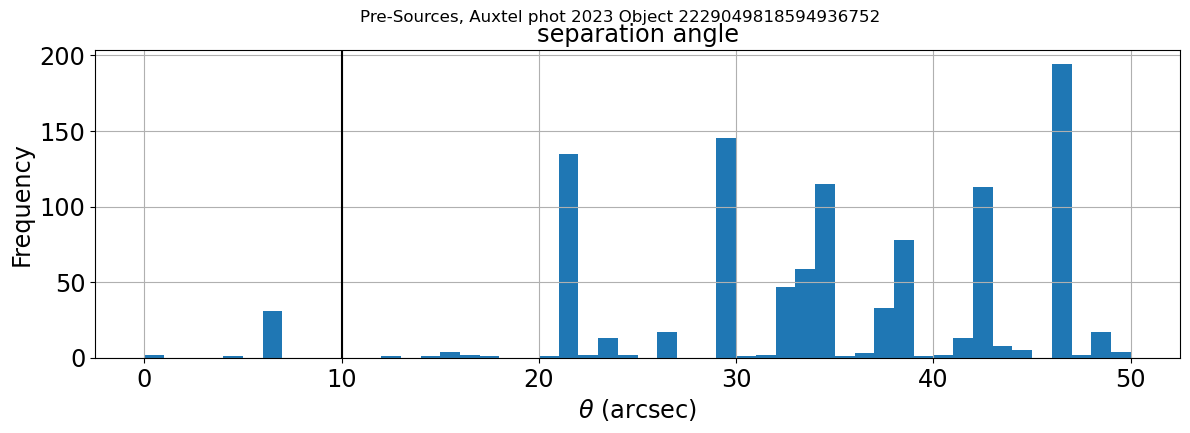

In [40]:
fig, ax = plt.subplots(1,1,figsize=(14,4))
df['sep'].plot(kind="hist",bins=50,range=(0,50),ax=ax,grid=True,title="separation angle")
ax.axvline(cut_arcsc,color="k")
ax.set_xlabel("$\\theta$ (arcsec)")
plt.suptitle(suptitle)

In [41]:
selection3 = df['sep']< cut_arcsc
df = df[selection3 ]

## Magnitudes

In [42]:
df["psfMag"] = df["psfFlux"].map(convert_fluxtomag)
df["gaussianMag"] = df["gaussianFlux"].map(convert_fluxtomag)
df["calibMag"] = df["calibFlux"].map(convert_fluxtomag)

/tmp/ipykernel_53683/4088867659.py:12: RuntimeWarning: invalid value encountered in log10
  return -2.50 * np.log10(x) + 31.4


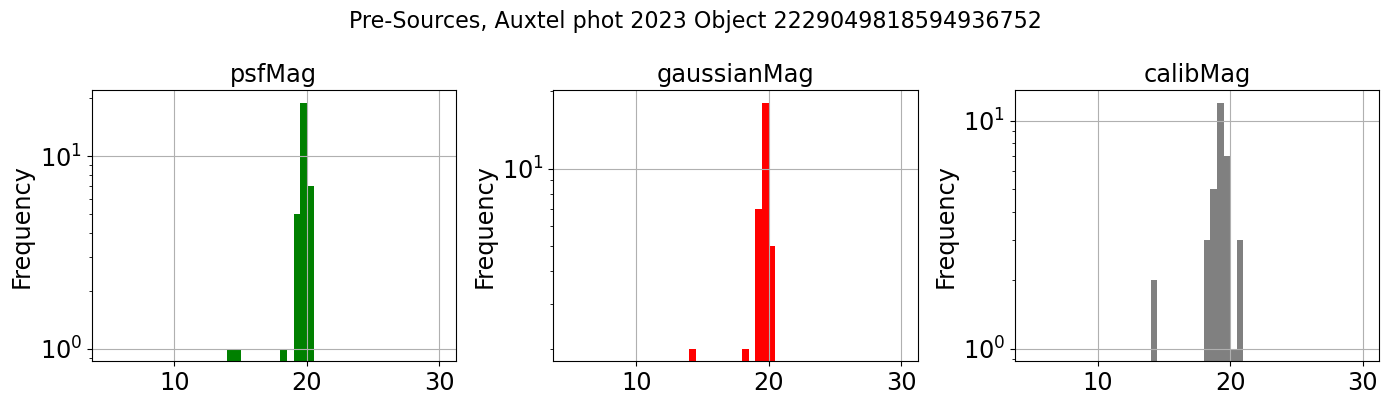

In [43]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(14,4))

df['psfMag'].plot(kind="hist",bins=50,range=(5,30),facecolor="g",logy=True,grid=True,title="psfMag",ax=ax1)
df['gaussianMag'].plot(kind="hist",bins=50,range=(5,30),facecolor="r",logy=True,grid=True,title="gaussianMag",ax=ax2)
df['calibMag'].plot(kind="hist",bins=50,range=(5,30),facecolor="grey",logy=True,grid=True,title="calibMag",ax=ax3)
plt.suptitle(suptitle,y=1.0,fontsize=16)
plt.tight_layout()


## Convert dateobs into datetime

In [44]:
df[["dateobs","sep","band","ccdVisitId"]]

,dateobs,sep,band,ccdVisitId
sourceId,,,,
171629836274499725,2023-05-12 03:59:38.183,6.689111,r,40919741696
171629837348241563,2023-05-12 04:00:25.985,6.776423,r,40919741952
171629839495725278,2023-05-12 04:01:59.895,6.676964,i,40919742464
171629842716950696,2023-05-12 04:04:19.885,6.649979,r,40919743232
171629843790692711,2023-05-12 04:05:07.288,6.604363,r,40919743488
171629845938176475,2023-05-12 04:06:36.640,6.716028,i,40919744000
171629856675594469,2023-05-12 04:14:21.536,6.529302,r,40919746560
171629858823078233,2023-05-12 04:15:53.841,6.615055,i,40919747072
171629859896820063,2023-05-12 04:16:39.440,6.649895,i,40919747328


In [45]:
df["Time"] = pd.to_datetime(df['dateobs'])

<Axes: xlabel='Time'>

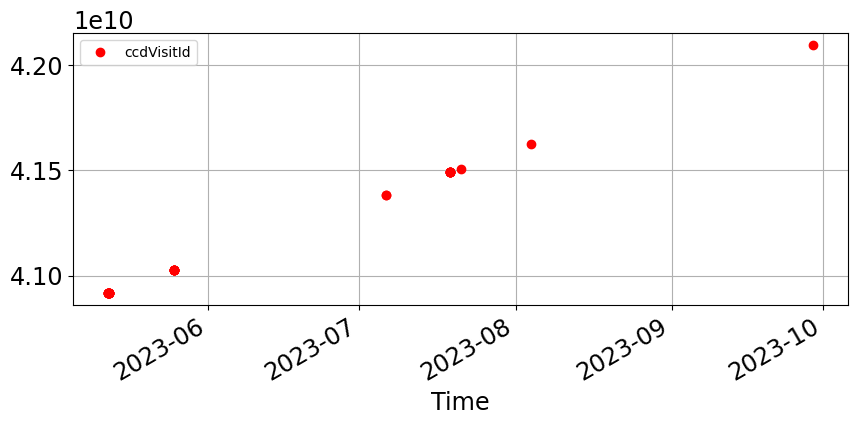

In [46]:
fig,ax = plt.subplots(1,1,figsize=(10,4))
df.plot(x="Time",y="ccdVisitId",marker='o',c="r",lw=0.0,ax=ax,grid=True)

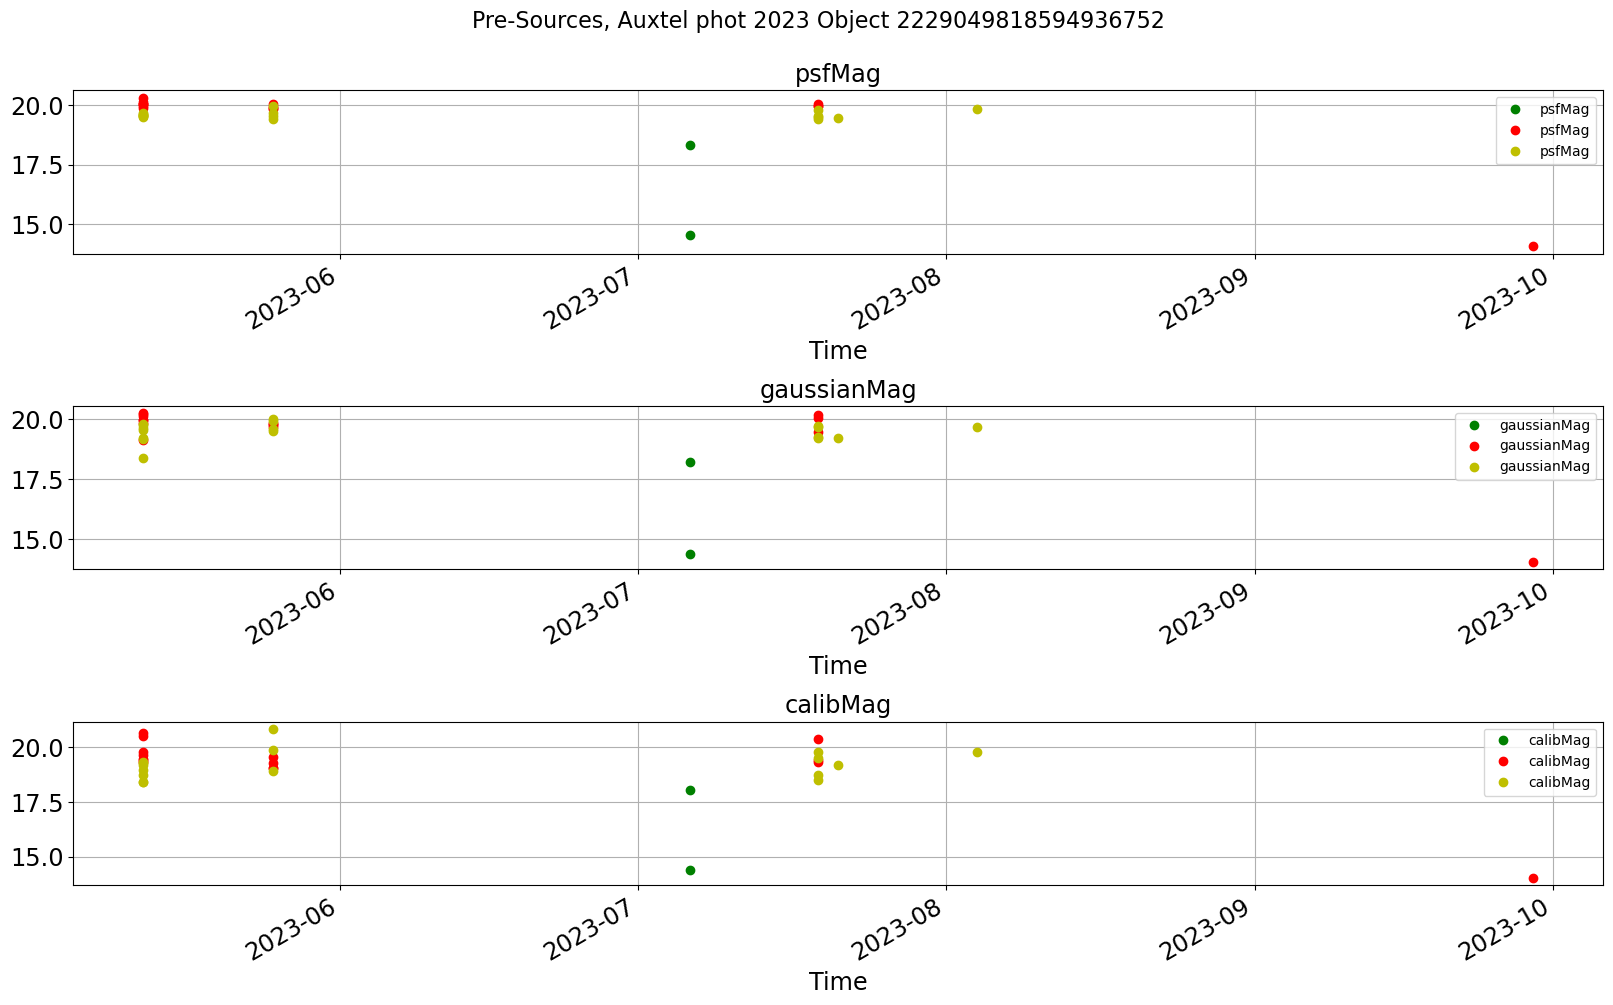

In [47]:
fig,(ax1,ax2,ax3) = plt.subplots(3,1)

df[df["band"]=="g"].plot(x="Time",y="psfMag",marker='o',c="g",lw=0.0,ax=ax1,grid=True)
df[df["band"]=="r"].plot(x="Time",y="psfMag",marker='o',c="r",lw=0.0,ax=ax1,grid=True)
df[df["band"]=="i"].plot(x="Time",y="psfMag",marker='o',c="y",lw=0.0,ax=ax1,grid=True)
ax1.set_title("psfMag")

df[df["band"]=="g"].plot(x="Time",y="gaussianMag",marker='o',c="g",lw=0.0,ax=ax2,grid=True)
df[df["band"]=="r"].plot(x="Time",y="gaussianMag",marker='o',c="r",lw=0.0,ax=ax2,grid=True)
df[df["band"]=="i"].plot(x="Time",y="gaussianMag",marker='o',c="y",lw=0.0,ax=ax2,grid=True)
ax2.set_title("gaussianMag")

df[df["band"]=="g"].plot(x="Time",y="calibMag",marker='o',c="g",lw=0.0,ax=ax3,grid=True)
df[df["band"]=="r"].plot(x="Time",y="calibMag",marker='o',c="r",lw=0.0,ax=ax3,grid=True)
df[df["band"]=="i"].plot(x="Time",y="calibMag",marker='o',c="y",lw=0.0,ax=ax3,grid=True)
ax3.set_title("calibMag")

#df.plot(x="Time",y="coord_dec",marker='o',c="g",lw=0.0,ax=ax2,grid=True)
plt.suptitle(suptitle,y=1.0,fontsize=16)
plt.tight_layout()

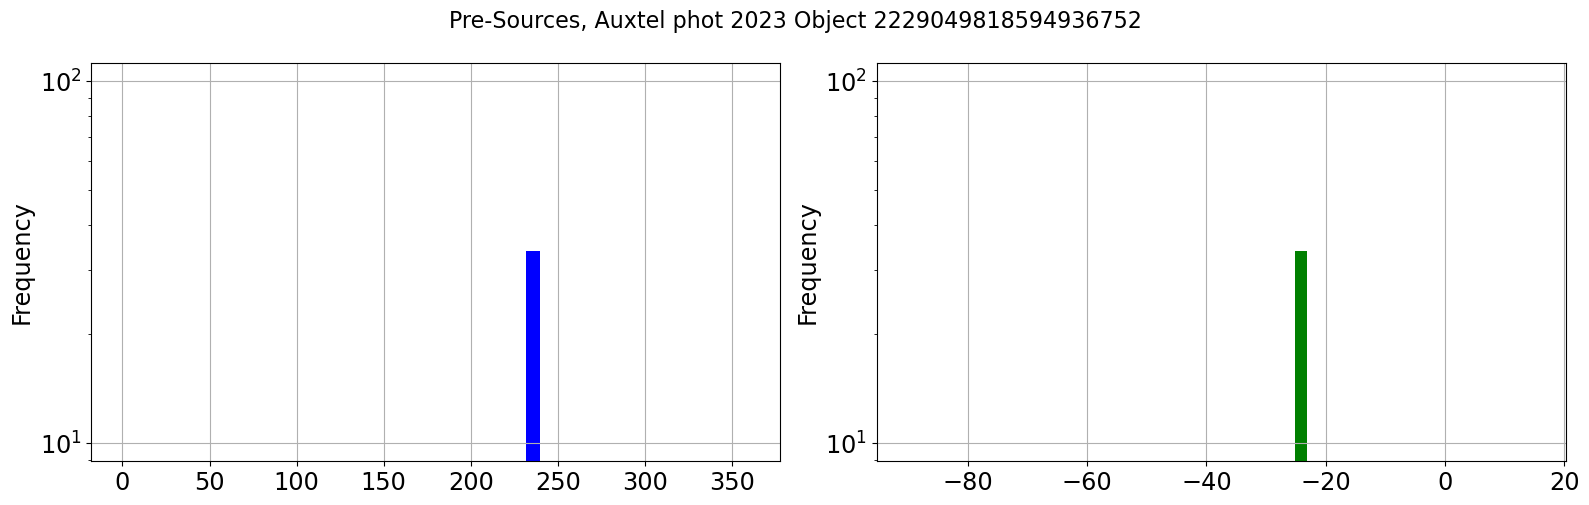

In [48]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16,5))
df_sel = df["coord_ra"]
df_sel.plot(kind="hist",x="coord_ra",bins=45,range=(0,360),facecolor="b",ax=ax1,grid=True,logy=True)
df_sel = df["coord_dec"]
df_sel.plot(kind="hist",x="coord_dec",bins=55,range=(-90,15),facecolor="g",ax=ax2,grid=True,logy=True)
plt.suptitle(suptitle,y=1.0,fontsize=16)
plt.tight_layout()

In [49]:
list_of_ccdvisits = df[["ccdVisitId"]].values.flatten()
list_of_ccdvisits

array([40919741696, 40919741952, 40919742464, 40919743232, 40919743488,
       40919744000, 40919746560, 40919747072, 40919747328, 40919747840,
       40919748096, 40919748352, 40919749632, 40919749888, 41028853760,
       41028854272, 41028858112, 41028860672, 41028861184, 41028861952,
       41028862976, 41028863488, 41381107200, 41381107200, 41490130432,
       41490130944, 41490131200, 41490133760, 41490134272, 41490134528,
       41490135040, 41506882816, 41624403200, 42094073856])

In [56]:
dataId = {'instrument': 'LATISS', 'detector': 0}
df_visit = butler.get('ccdVisitTable', dataId=dataId)

In [64]:
df_visit.columns

Index(['visitId', 'physical_filter', 'band', 'ra', 'dec', 'zenithDistance',
       'zeroPoint', 'psfSigma', 'skyBg', 'skyNoise', 'astromOffsetMean',
       'astromOffsetStd', 'nPsfStar', 'psfStarDeltaE1Median',
       'psfStarDeltaE2Median', 'psfStarDeltaE1Scatter',
       'psfStarDeltaE2Scatter', 'psfStarDeltaSizeMedian',
       'psfStarDeltaSizeScatter', 'psfStarScaledDeltaSizeScatter',
       'psfTraceRadiusDelta', 'maxDistToNearestPsf', 'decl', 'detector',
       'seeing', 'skyRotation', 'expMidpt', 'expMidptMJD', 'expTime',
       'obsStart', 'obsStartMJD', 'darkTime', 'xSize', 'ySize', 'llcra',
       'llcdec', 'ulcra', 'ulcdec', 'urcra', 'urcdec', 'lrcra', 'lrcdec'],
      dtype='object')

In [73]:
df_visit.loc[list_of_ccdvisits[0]]

visitId                                       2023051100437
physical_filter                            SDSSr_65mm~empty
band                                                      r
ra                                               239.965488
dec                                              -24.040603
zenithDistance                                    19.981991
zeroPoint                                         27.838413
psfSigma                                           5.475201
skyBg                                              7.817419
skyNoise                                           7.680901
astromOffsetMean                                   0.022199
astromOffsetStd                                    0.011524
nPsfStar                                                 59
psfStarDeltaE1Median                              -0.006418
psfStarDeltaE2Median                               0.001363
psfStarDeltaE1Scatter                              0.026182
psfStarDeltaE2Scatter                   

In [86]:
#print(list(df_visit.index))

In [57]:
#results = set(butler.registry.queryDataIds('visit', dataId={"tract":tract_selected, "skymap":"latiss_v1"}))
#pprint(results)

In [87]:
datasettype = 'calexp.visitInfo'
for ccdvisit in list_of_ccdvisits:
    try:
        visitid = df_visit.loc[ccdvisit]["visitId"]
        dayobs = visitid //100_000
        dataId = {'visit': visitid, 'detector': 0}
        visitInfo = butler.get(datasettype, dataId=dataId )
        calexp = butler.get('calexp', dataId=dataId)
        #print(visitInfo)
        print(visitid,dayobs,":","az=",visitInfo.boresightAzAlt[0],"alt=",visitInfo.boresightAzAlt[1],"am=",visitInfo.boresightAirmass)
    except Exception as err:
        print(f"Unexpected {err=}, {type(err)=}")
        

2023051100437 20230511 : az= 1.35313 rad alt= 1.2188 rad am= 1.06487820815698
2023051100438 20230511 : az= 1.35 rad alt= 1.22148 rad am= 1.06384316570543
2023051100440 20230511 : az= 1.34294 rad alt= 1.22734 rad am= 1.06160899808711
2023051100443 20230511 : az= 1.33185 rad alt= 1.23572 rad am= 1.05848943629892
2023051100444 20230511 : az= 1.32909 rad alt= 1.23836 rad am= 1.05751507720064
2023051100446 20230511 : az= 1.32153 rad alt= 1.24389 rad am= 1.05551414688431
2023051100456 20230511 : az= 1.27746 rad alt= 1.27273 rad am= 1.04577287030931
2023051100458 20230511 : az= 1.26814 rad alt= 1.27833 rad am= 1.04399489053738
2023051100459 20230511 : az= 1.26362 rad alt= 1.28082 rad am= 1.04322723303561
2023051100461 20230511 : az= 1.25418 rad alt= 1.28641 rad am= 1.04152194237661
2023051100462 20230511 : az= 1.25032 rad alt= 1.289 rad am= 1.04073876882317
2023051100463 20230511 : az= 1.17879 rad alt= 1.32449 rad am= 1.03084788108446
2023051100468 20230511 : az= 1.14757 rad alt= 1.33756 rad 